In [ ]:
#: the usual imports
import babypandas as bpd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

plt.style.use('fivethirtyeight')

# Lecture 18

### Confidence Intervals, Mean & Spread

## Why the bootstrap works

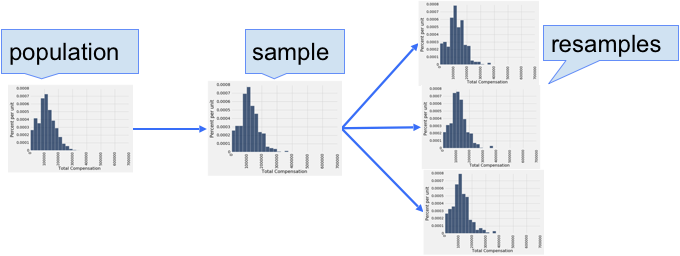

## Why we need the bootstrap

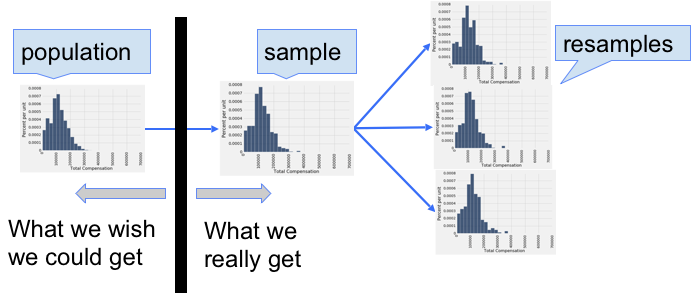

## Recall: median salary of San Diego city employees

In [ ]:
#: read in the data
population = bpd.read_csv('salaries.csv').get(['Total Pay'])
population

## The bootstrap median salary

In [ ]:
#: take a sample of size 500
sample = population.sample(500, replace=False)
sample_median = np.median(sample.get('Total Pay'))

n_resamples = 5000

boot_medians = np.array([])
for i in range(n_resamples):
    # perform bootstrap resampling
    resample = sample.sample(500, replace=True)
    
    # compute the median
    median = resample.get('Total Pay').median()
    
    # tack it on to our list of medians
    boot_medians = np.append(boot_medians, median)

In [ ]:
left = np.percentile(boot_medians, 2.5)
right = np.percentile(boot_medians, 97.5)
[left, right]

In [ ]:
#: visualize
bpd.DataFrame().assign(BootstrapMedians=boot_medians).plot(kind='hist', density=True)
plt.plot([left, right], [0, 0], color='lime', linewidth=5, alpha=0.9, zorder=2)
plt.scatter(sample_median, 0, color='red', s=80).set_zorder(3)

## CI's from different bootstraps
* Confidence intervals from 200 different bootstrap samples

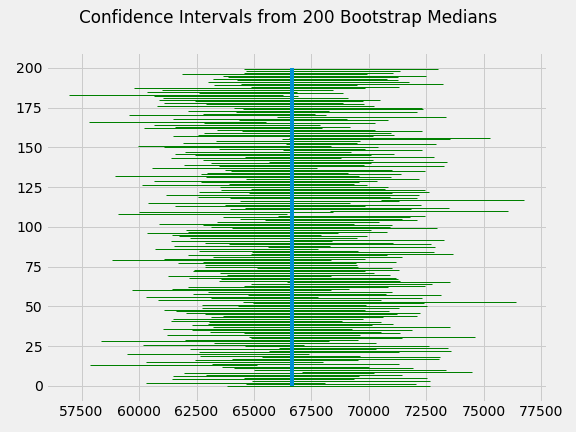

## Which CI's don't contain the median?

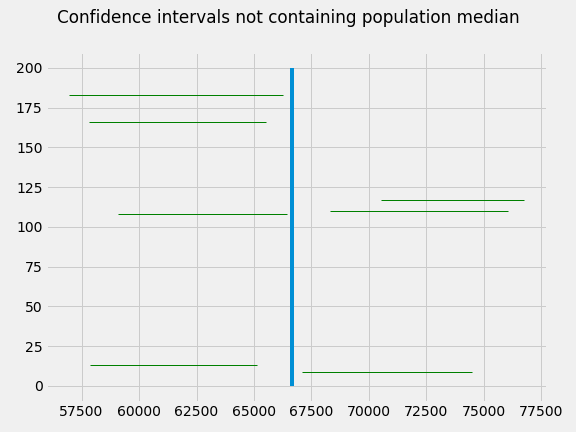

## 95% Confidence Interval
* Interval of estimates of a parameter
* Based on random sampling
* The confidence in the the process that generated the interval:
    - It generates a "good" interval about 95% of the time.

# Confidence Intervals for Testing

## Using a CI for testing

* Null hypothesis: Population average = x
* Alternative hypothesis: Population average ≠ x
* Cutoff for P-value: p%
* Method:
    - Construct a (100-p)% confidence interval for the population average
    - If x is not in the interval, reject the null
    - If x is in the interval, can’t reject the null

### Among city of SD employees,
* do men and women make similar total pay?

In [ ]:
population = bpd.read_csv('salaries.csv')
population

### How do we create a column labeling sex?
* Download list of baby names from the internet!
* `merge` to the SD employee data
    - Caution: this join isn't perfect!

In [ ]:
names = bpd.read_csv('baby-names.csv')
names

## Making a list of names and associated sex
* Careful of unisex names!
* Use the sex that is most often associated to the name

## Approach:
* Count number of times each name is M/F; take most common.
* Trick: sum M as positive, F as negative numbers; total.

In [ ]:
with_sign = names.assign(
    sign=np.where(names.get('sex') == 'boy', 1, -1)
)
with_sign

## Make M positive, F negative

In [ ]:
with_signed_number = with_sign.assign(
    number=with_sign.get('sign') * with_sign.get('number')
)
with_signed_number

In [ ]:
with_signed_total = with_signed_number.groupby('name').sum()
with_signed_total

In [ ]:
name_map = with_signed_total.assign(
    sex=np.where(with_signed_total.get('number') > 0, 'M', 'F')
).get(['sex'])
name_map

In [ ]:
# Add a First Name column to join SD data to names

def get_firstname(s):
    return s.split()[0]

population2join = population.assign(
    FirstName=population.get('Employee Name').apply(get_firstname)
)
population2join

In [ ]:
# Join tables
pop_with_sex = population2join.merge(name_map, left_on='FirstName', right_index=True)
pop_with_sex

In [ ]:
avg_pay_by_sex = pop_with_sex.groupby('sex').mean().get(['Total Pay'])
avg_pay_by_sex

In [ ]:
men = avg_pay_by_sex.get('Total Pay').loc['M']
women = avg_pay_by_sex.get('Total Pay').loc['F']
print('women median:\t %f' % women)
print('men median:\t %f' % men)

In [ ]:
#: visualize
bpd.DataFrame().assign(BootstrapMedians=boot_medians).plot(kind='hist', density=True)
plt.scatter(women, 0, color='red', s=80, zorder=2)
plt.scatter(men, 0, color='blue', s=80, zorder=2)
plt.plot([left, right], [0, 0], color='lime', linewidth=5, zorder=1)
plt.legend(['95% CI', 'Bootstrap Medians', 'Women (Median)', 'Men (Median)'])

### The median salaries of men/women are:
* significantly higher/lower than the population median.
* The test doesn't state *why* they're different.
* City employees are fixed for any given job title.
    - Disparity is due to gender inbalance of job-types.
    - question: FT/PT analysis?

### Job title: fire related

In [ ]:
fire_related = pop_with_sex[pop_with_sex.get('Job Title').str.contains('Fire')]
fire_related

In [ ]:
# gender breakdown
fire_related.groupby('sex').count().get(['Employee Name'])

In [ ]:
# median pay
fire_related.get('Total Pay').median()

### Job title: library related

In [ ]:
library_related = pop_with_sex[pop_with_sex.get('Job Title').str.contains('Libr')]
library_related

In [ ]:
# gender breakdown
library_related.groupby('sex').count().get(['Employee Name'])

In [ ]:
# median pay
library_related.get('Total Pay').median()

# Center and Spread

## Questions 
* How can we quantify natural concepts like “center” and “variability”?
* Why do many of the empirical distributions that we generate come out bell shaped?
* How is sample size related to the accuracy of an estimate?

## The Average (or Mean)

Given Data: $2, 3, 3, 9$, the average (or mean) is:
$$\rm{Average } = \frac{2 + 3 + 3 + 9}{4} = 4.25$$

## The Average (or Mean)

* Need not be a value in the collection
* Need not be an integer even if the data are integers
* Somewhere between min and max, but not necessarily halfway in between
* Same units as the data.
* Smoothing operator: collect all the contributions in one big pot, then split evenly

## The Median

- A median is a number in the "middle" of the data.
- Sort the data, pick number in the middle.
    - If there are two middle numbers, pick either (or any number between).
- Example: Median(1, 4, 7, 12, 32) is 7.
- Example: Median(1, 4, 7, 12) is 4 or 7 or any number between, like 4.2

### Example

Create a data set that has this histogram. (You can do it with a short list of whole numbers.) 

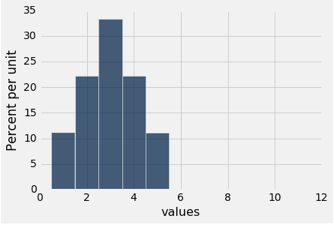

What are its median and mean?

In [ ]:
bpd.DataFrame().assign(data=[1, 2, 2, 3, 3, 3, 4, 4, 5]).plot(kind='hist', bins=np.arange(.5, 12.5), density=True)

### Discussion Question

Are the medians of these two distributions the same or different? Are the means the same or different? If you say “different,” then say which one is bigger.

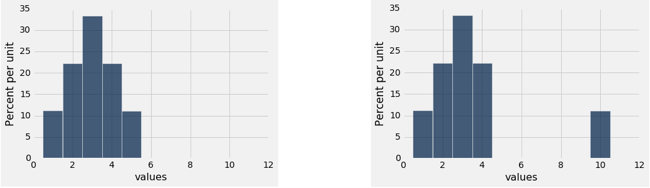

- A) All the same
- B) Means are different, medians are same
- C) Means are same, medians are different
- D) Everything is different

### Answer

In [ ]:
#:
tbl1 = bpd.DataFrame().assign(data=[1, 2, 2, 3, 3, 3, 4, 4, 5])
tbl2 = bpd.DataFrame().assign(data=[1, 2, 2, 3, 3, 3, 4, 4, 10])

In [ ]:
#:
print(
    'median #1:\t%f' % tbl1.get('data').median(),
    'median #2:\t%f' % tbl2.get('data').median(),
    'mean #1:\t%f' % tbl1.get('data').mean(),
    'mean #2:\t%f' % tbl2.get('data').mean(),
    sep='\n'
)

## Comparing Mean and Median
* Mean: Balance point of the histogram
* Median: Half-way point of data; half the area of histogram is on either side of median
* If the distribution is symmetric about a value, then that value is both the average and the median.
* If the histogram is skewed, then the mean is pulled away from the median in the direction of the tail.

## Discussion Question

Which is bigger:

- A) The mean
- B) The median

In [ ]:
delays = bpd.read_csv('delays.csv').get('Delay')
delays.plot(kind='hist', bins=np.arange(-.5, 210, 10), density=True)
plt.title('Flight Delays')
plt.xlabel('Delay (minutes)')

In [ ]:
print('mean:\t%f' % delays.mean())
print('median:\t%f' % delays.median())
delays.plot(kind='hist', bins=np.arange(-.5, 210, 10), density=True)
plt.title('Flight Delays')
plt.xlabel('Delay (minutes)')

## The Mean vs the Median

- The median is more **robust** to **outliers**.

## Example

- Suppose we have the net worth of all UCSD students:

In [ ]:
worths = np.random.lognormal(5.5, 1.25, 20_000)

In [ ]:
worths.mean()

In [ ]:
np.median(worths)

In [ ]:
plt.hist(worths, bins=np.arange(0, 2_000, 100))

## Example

- Now Jeff Bezos (net worth: 127 billion) enrolls as a Data Science major

In [ ]:
new_worths = np.append(worths, 127e9)

In [ ]:
np.mean(new_worths)

In [ ]:
np.median(new_worths)

# Standard Deviation

## Measuring Width

- How **wide** is the distribution?

**Plan A:** “biggest value - smallest value”
* Doesn’t tell us much about the shape of the distribution

**Plan B:** "the standard deviation"
* Measures variability around the mean

### Deviations from the mean

In [ ]:
data = np.array([2, 3, 3, 9])

In [ ]:
mean = data.mean()
mean

In [ ]:
deviations = data - mean
deviations

## The average deviation?

In [ ]:
deviations.mean()

## Average **squared** deviation

a.k.a, the **variance**

In [ ]:
deviations**2

In [ ]:
variance = (deviations**2).mean()
variance

## Standard deviation

- Suppose our data has units (say, minutes)
- Variance has units of minutes^2
- Correction: take square root

In [ ]:
# Standard Deviation (SD) is the square root of the variance
sd = variance ** 0.5
sd

## Standard Deviation
* numpy function: `np.std`
* Standard deviation (SD) measures roughly how far the data are from their average
* SD has the same units as the data

In [ ]:
np.std(data)

## Why use the SD?

No matter what the shape of the distribution, the bulk of the data are in the range “average ± a few SDs”

## Chebyshev’s Inequality

No matter what the shape of the distribution, the proportion of values in the range “average ± z SDs” is at least 

$$1 - 1/z²$$

## Chebyshev's Bounds

|Range|Proportion|
|---|---|
|average ± 2 SDs|	at least 1 - 1/4   (75%)|
|average ± 3 SDs|	at least 1 - 1/9   (88.888…%)|
|average ± 4 SDs|	at least 1 - 1/16 (93.75%)|
|average ± 5 SDs|	at least 1 - 1/25  (96%)|

No matter what the distribution is!

## Example

In [ ]:
nba = bpd.read_csv('nba2013.csv')
nba.plot(kind='hist', y='Height', density=True, bins=np.arange(69.5, 90, 1))
nba.get('Height').describe()

## Example

- Mean $\approx$ 79
- STD $\approx$ 3.45
- *At least* 75% of the data is in $[79 - 2\times 3.45,\, 79 + 2\times 3.45] = [72.1, 85.9]$
- *At least* 88% of the data is in $[79 - 3\times 3.45,\, 79 +3\times 3.45] = [68.65, 89.35]$

## Chebyshev's Inequality

- Chebyshev works no matter the distribution
- But if we know the type of the distribution (e.g., Normal), we can say more!